# Part 2: Classification
### 1. Overview

Columns:
* **id** - number of the row
* **Clump Thickness** - товщина пухлини
* **Uniformity of Cell Size** - рівномірнісь розміру
* **Uniformity of Cell Shape** - рівномірність форми
* **Marginal Adhesion** - рівень інтеракції клітин, що по краях, із сусідніми клітинами
* **Single Epithelial Cell Size** - розмір однієї ураженої клітини
* **Bare Nuclei** - ядра, які дегенерують, змінюються у ненормальному руслі
* **Bland Chromatin** - описує рівномірну "структуру" ядра, що спостерігається у доброякісних клітина
* **Normal Nucleoli** - кількісит нормальних ядер
* **Mitoses** - найпоширеніший спосіб поділу ядра
* **Class** - клас пухлини (2 for benign, 4 for malignant)

In [109]:
# data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# regression models
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 
# classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
# extra
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy

## 2. Data Investigation

In [110]:
import pandas as pd
df = pd.read_csv('cancer-classification.csv')
df.head(3)

,Unnamed: 0,Id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1000025,5,1,1,1,2,1,3,1,1,2
1,1,1002945,5,4,4,5,7,10,3,2,1,2
2,2,1015425,3,1,1,1,2,2,3,1,1,2


##### Clear-up the data

In [111]:
df = df.drop(['Unnamed: 0', 'Id'], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcea2672310>,
      dtype=object)

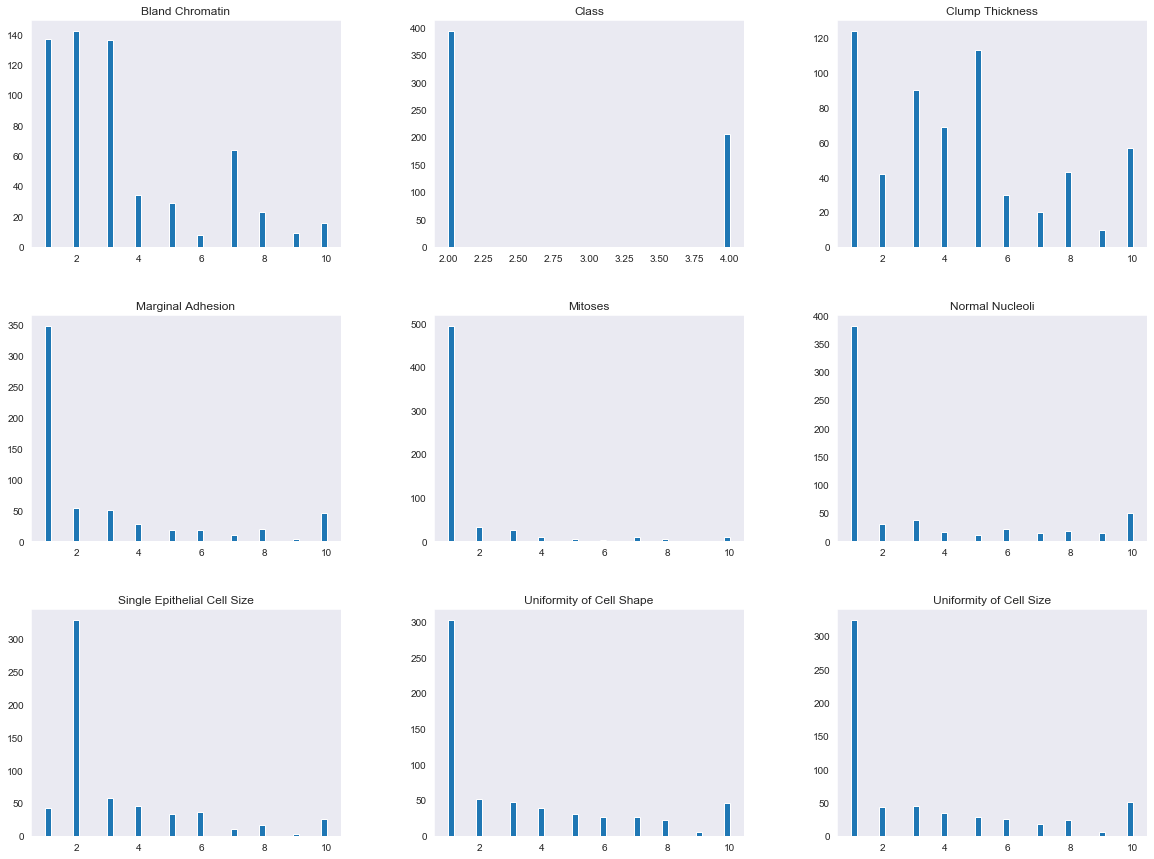

In [112]:
df.hist(bins=50, figsize=(20, 15), grid=False)

### Investigate Null Values

In [113]:
df.isnull().sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [114]:
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,4.419732,3.088629,3.158863,2.769231,3.200669,3.396321,2.832776,1.560201,2.685619
std,2.797357,2.975135,2.916455,2.823138,2.187187,2.429947,3.028419,1.621326,0.950092
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,3.000000,4.000000,4.000000,3.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


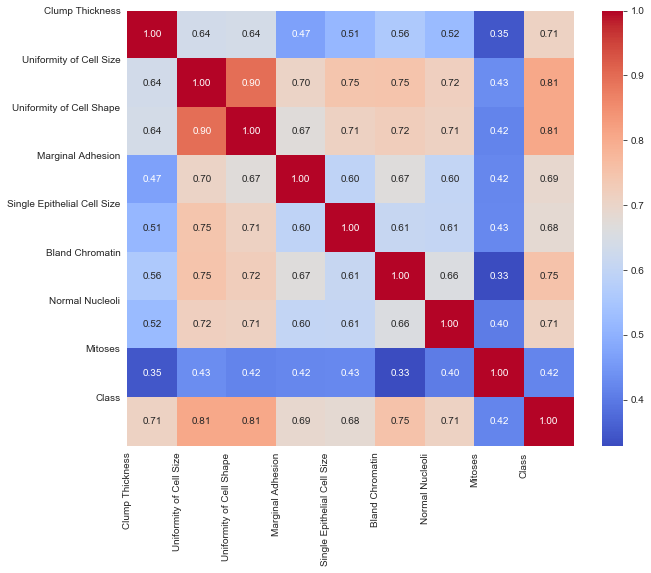

In [115]:
corr = df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns)
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

We can see a strong correlation between two features: Uniformity of Cell Size and Shape, so we can drop one of them without losing important data.

In [116]:
df = df.drop(['Uniformity of Cell Size'], axis=1)

### 2. Data preprocessing

In [117]:
df = pd.get_dummies(df)
df.head(3)

,Clump Thickness,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Bare Nuclei_1,Bare Nuclei_10,Bare Nuclei_2,Bare Nuclei_3,Bare Nuclei_4,Bare Nuclei_5,Bare Nuclei_6,Bare Nuclei_7,Bare Nuclei_8,Bare Nuclei_9,Bare Nuclei_?
0,5,1,1,2,3,1,1,2,1,0,0,0,0,0,0,0,0,0,0
1,5,4,5,7,3,2,1,2,0,1,0,0,0,0,0,0,0,0,0
2,3,1,1,2,3,1,1,2,0,0,1,0,0,0,0,0,0,0,0


In [118]:
X = df.drop(['Class'], axis = 1).values
y = df['Class'].values.reshape(-1, 1)

#### Seperate training, test and validation datasets

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.25, random_state=1)

In [120]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of X_val: ",X_val.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)
print("Shape of y_val",y_val.shape)

Shape of X_train:  (358, 18)
Shape of X_test:  (120, 18)
Shape of X_val:  (120, 18)
Shape of y_train:  (358, 1)
Shape of y_test (120, 1)
Shape of y_val (120, 1)


## 3. Train the classification model

In [121]:
X_train1, X_test1, y_train1, y_test1 = deepcopy(X_train), deepcopy(X_test), deepcopy(y_train), deepcopy(y_test)
X_train2, X_test2, y_train2, y_test2 = deepcopy(X_train), deepcopy(X_test), deepcopy(y_train), deepcopy(y_test)
X_train3, X_test3, y_train3, y_test3 = deepcopy(X_train), deepcopy(X_test), deepcopy(y_train), deepcopy(y_test)
X_train4, X_test4, y_train4, y_test4 = deepcopy(X_train), deepcopy(X_test), deepcopy(y_train), deepcopy(y_test)

#### Logistic Regression

In [126]:
c1 = LogisticRegression().fit(X_train1, y_train1.ravel())
y1_pred = c1.predict(X_test1)

print(f"precision_score:\t{precision_score(y_test1, y1_pred, average='macro')}")
print(f"recall_score:\t\t{recall_score(y_test1, y1_pred, average='macro')}")
print(f"f1_score:\t\t{f1_score(y_test1, y1_pred, average='macro')}")

precision_score:	0.9777777777777779
recall_score:		0.987012987012987
f1_score:		0.9820574162679425


#### SVM

In [127]:
c2 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
c2.fit(X_train2, y_train2.ravel())
y2_pred = c2.predict(X_test2)

print(f"precision_score:\t{precision_score(y_test2, y2_pred, average='macro')}")
print(f"recall_score:\t\t{recall_score(y_test2, y2_pred, average='macro')}")
print(f"f1_score:\t\t{f1_score(y_test2, y2_pred, average='macro')}")

precision_score:	0.9706937799043063
recall_score:		0.9753850800362428
f1_score:		0.9729546991210277


#### Gradient Boosting Classifier

In [128]:
c3 = GradientBoostingClassifier()
c3.fit(X_train3, y_train3.ravel())
y3_pred = clf3.predict(X_test3)

print(f"precision_score:\t{precision_score(y_test3, y3_pred, average='macro')}")
print(f"recall_score:\t\t{recall_score(y_test3, y3_pred, average='macro')}")
print(f"f1_score:\t\t{f1_score(y_test3, y3_pred, average='macro')}")

precision_score:	0.9706937799043063
recall_score:		0.9753850800362428
f1_score:		0.9729546991210277


#### KNeighborsClassifier

In [129]:
c4 = KNeighborsClassifier(n_neighbors=3)
c4.fit(X_train4, y_train4.ravel())
y4_pred = c4.predict(X_test4)

print(f"precision_score:\t{precision_score(y_test4, y4_pred, average='macro')}")
print(f"recall_score:\t\t{recall_score(y_test4, y4_pred, average='macro')}")
print(f"f1_score:\t\t{f1_score(y_test4, y4_pred, average='macro')}")

precision_score:	0.945635759589248
recall_score:		0.945635759589248
f1_score:		0.945635759589248
